# Andmete puhastamine (koduülesanne)

Selles notebookis teeme OIS andmete eeltöötluse filtreerimise ja RAG kasutuse jaoks.

Põhimõtted:
- eelistame `version__*` veerge,
- kui `version__*` info puudub, kasutame üldist (`base`) veergu,
- JSON-väljad teisendame loetavaks tekstiks,
- loome lõpus ühe koondvälja `description`, mida saab kasutada RAG sisendina.

Sisend: `toorandmed/toorandmed_aasta.csv`  
Väljund: `toorandmed/puhastatud_andmed.csv`


In [1]:
import json
import re
from html import unescape
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 150)

INPUT_FILE = Path("toorandmed/toorandmed_aasta.csv")
OUTPUT_FILE = Path("toorandmed/puhastatud_andmed.csv")

if not INPUT_FILE.exists():
    raise FileNotFoundError(f"Sisendfail puudub: {INPUT_FILE}")

df_raw = pd.read_csv(INPUT_FILE, low_memory=False)

print(f"Andmestik loetud: {df_raw.shape[0]} rida, {df_raw.shape[1]} veergu")
print(f"Sisendfail: {INPUT_FILE}")
print(f"Väljundfail: {OUTPUT_FILE}")

Andmestik loetud: 3156 rida, 229 veergu
Sisendfail: toorandmed/toorandmed_aasta.csv
Väljundfail: toorandmed/puhastatud_andmed.csv


## 1) Toorete näidete vaatamine (vibecoding sisend)

Vaatame 10 toorest rida valitud veergudega, et oleks näha, millist sisu tuleb puhastada.


In [2]:
raw_preview_cols = [
    "code",
    "title__et",
    "version__title__et",
    "overview__description__et",
    "version__overview__description__et",
    "version__overview__study_languages",
    "version__additional_info__study_levels",
    "overview__objectives",
    "version__overview__objectives",
    "overview__learning_outcomes",
    "version__overview__learning_outcomes",
    "additional_info__prerequisites",
    "version__grading__grade_evaluation__et",
]
raw_preview_cols = [c for c in raw_preview_cols if c in df_raw.columns]

display(df_raw[raw_preview_cols].head(10))

,code,title__et,version__title__et,overview__description__et,version__overview__description__et,version__overview__study_languages,version__additional_info__study_levels,overview__objectives,version__overview__objectives,overview__learning_outcomes,version__overview__learning_outcomes,additional_info__prerequisites,version__grading__grade_evaluation__et
0,OIEO.06.046,Rahvusvaheline eraõigus,Rahvusvaheline eraõigus,"Kursuse raames käsitletakse rahvusvahelise eraõiguse põhiteemasid, terminoloogiat ja kujunemist, tutvustatakse ja õpetatakse praktikas kasutama Ee...","Kursuse raames käsitletakse rahvusvahelise eraõiguse põhiteemasid, terminoloogiat ja kujunemist, tutvustatakse ja õpetatakse praktikas kasutama Ee...","[{""code"": ""et"", ""en"": ""Estonian"", ""et"": ""eesti keel""}]","[{""code"": ""master"", ""en"": ""master's studies"", ""et"": ""magistriõpe""}]","[{""en"": ""The purpose of the course is to teach the theoretical principles of private international law (PIL); to explain the key-notions of PIL an...","[{""en"": ""The purpose of the course is to teach the theoretical principles of private international law (PIL); to explain the key-notions of PIL an...","[{""en"": ""At the end of the course the student is able to:"", ""et"": ""Kursuse lõpuks peab üliõpilane olema võimeline:""}, {""en"": ""-\texplain the natur...","[{""en"": ""At the end of the course the student is able to:"", ""et"": ""Kursuse lõpuks peab üliõpilane olema võimeline:""}, {""en"": ""-\texplain the natur...",NaN,100% kirjalik eksam.
1,KKSB.05.092,Praktiseerimine töökeskkonnas,Praktiseerimine töökeskkonnas,Aines Praktiseerimine töökeskkonnas laiendab üliõpilane oma silmaringi füsioteraapia valdkonnas toimetades töökeskkonnas vabatahtlikuna.,Aines Praktiseerimine töökeskkonnas laiendab üliõpilane oma silmaringi füsioteraapia valdkonnas toimetades töökeskkonnas vabatahtlikuna.,"[{""code"": ""et"", ""en"": ""Estonian"", ""et"": ""eesti keel""}]","[{""code"": ""bachelor"", ""en"": ""bachelor's studies"", ""et"": ""bakalaureuseõpe""}]","[{""en"": ""The aim of practice is gaining work experience in the work environment"", ""et"": ""Aine eesmärgiks on töökogemuse omandamine töökeskkonnas""}]","[{""en"": ""The aim of practice is gaining work experience in the work environment"", ""et"": ""Aine eesmärgiks on töökogemuse omandamine töökeskkonnas""}]","[{""en"": ""Student:"", ""et"": ""Õpilane:""}, {""en"": ""understands and follows the work ethic and organization in the work environment;;"", ""et"": ""mõistab ...","[{""en"": ""Student:"", ""et"": ""Õpilane:""}, {""en"": ""understands and follows the work ethic and organization in the work environment;;"", ""et"": ""mõistab ...",NaN,NaN
2,ARKI.02.030,Lastekirurgia,Lastekirurgia,"Lastekirurgiliste haiguste diagnoosimise ja ravi printsiibid, metoodika ja taktika. Antud aine moodustab ühe osa õppeainest ""Kirurgia"" (12 EAP)","Lastekirurgiliste haiguste diagnoosimise ja ravi printsiibid, metoodika ja taktika. Antud aine moodustab ühe osa õppeainest ""Kirurgia"" (12 EAP)","[{""code"": ""en"", ""en"": ""English"", ""et"": ""inglise keel""}]","[{""code"": ""bachelor_master"", ""en"": ""integrated bachelor's and master's studies"", ""et"": ""integreeritud bakalaureuse- ja magistriõpe""}]","[{""en"": ""The aims of the course are: to provide theoretical knowledge of the basics of paediatric surgery (general pediatric surgery, surgery of n...","[{""en"": ""The aims of the course are: to provide theoretical knowledge of the basics of paediatric surgery (general pediatric surgery, surgery of n...","[{""en"": ""After completing the course the student knows"", ""et"": ""Õppe tulemusena peavad üliõpilased teadma:""}, {""en"": ""1) the epidemiology, etiolog...","[{""en"": ""After completing the course the student knows"", ""et"": ""Õppe tulemusena peavad üliõpilased teadma:""}, {""en"": ""1) the epidemiology, etiolog...","[{""code"": ""AR00.00.016"", ""credits"": 17, ""last_update"": ""2024-02-05T11:04:36"", ""required"": true, 

## 2) Abifunktsioonid

In [3]:
def get_series(frame: pd.DataFrame, col: str) -> pd.Series:
    if col in frame.columns:
        return frame[col]
    return pd.Series(np.nan, index=frame.index)


def parse_json_safe(value):
    if pd.isna(value):
        return None
    if isinstance(value, (list, dict)):
        return value
    if isinstance(value, str):
        value = value.strip()
        if not value:
            return None
        try:
            return json.loads(value)
        except json.JSONDecodeError:
            return None
    return None


def as_list(data):
    if data is None:
        return []
    if isinstance(data, list):
        return data
    return [data]


def dedupe_keep_order(values):
    out = []
    seen = set()
    for v in values:
        if v not in seen:
            seen.add(v)
            out.append(v)
    return out


def clean_text(value):
    if pd.isna(value):
        return np.nan

    text = str(value)
    text = unescape(text)
    text = re.sub(r"<[^>]+>", " ", text)
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    text = re.sub(r"[ \t]+", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    text = text.strip()

    return text if text else np.nan


def prefer_version(frame: pd.DataFrame, version_col: str, base_col: str) -> pd.Series:
    version = get_series(frame, version_col).replace("", np.nan)
    base = get_series(frame, base_col).replace("", np.nan)
    return version.fillna(base)


def extract_localized_text(json_value, lang: str):
    data = parse_json_safe(json_value)
    if data is None:
        return np.nan

    if isinstance(data, dict):
        value = data.get(lang)
        return clean_text(value) if value else np.nan

    if isinstance(data, list):
        parts = []
        for item in data:
            if isinstance(item, dict):
                value = item.get(lang)
                value = clean_text(value) if value else np.nan
                if pd.notna(value):
                    parts.append(value)
        parts = dedupe_keep_order(parts)
        return " ".join(parts) if parts else np.nan

    return np.nan


def extract_languages_et(json_value):
    data = parse_json_safe(json_value)
    items = as_list(data)

    values = []
    for item in items:
        if isinstance(item, dict):
            val = item.get("et") or item.get("en") or item.get("code")
            if val:
                values.append(str(val).strip())

    values = dedupe_keep_order([v for v in values if v])
    return ", ".join(values) if values else np.nan


def extract_study_levels(json_value):
    data = parse_json_safe(json_value)
    items = as_list(data)

    levels = []
    for item in items:
        if isinstance(item, dict):
            val = item.get("et") or item.get("en") or item.get("code")
            if val:
                levels.append(str(val).strip())

    levels = dedupe_keep_order([v for v in levels if v])
    return ", ".join(levels) if levels else np.nan


def format_course_ref(item: dict):
    if not isinstance(item, dict):
        return None

    code = item.get("code")
    title = item.get("title")
    title_text = None

    if isinstance(title, dict):
        title_text = title.get("et") or title.get("en")
    elif isinstance(title, str):
        title_text = title

    if code and title_text:
        return f"{code} ({title_text})"
    if code:
        return str(code)
    if title_text:
        return str(title_text)
    return None


def extract_prerequisites(json_value):
    data = parse_json_safe(json_value)
    requirements = as_list(data)

    parts = []
    for req in requirements:
        if not isinstance(req, dict):
            continue

        options = []
        main_ref = format_course_ref(req)
        if main_ref:
            options.append(main_ref)

        alternatives = req.get("alternatives")
        for alt in as_list(alternatives):
            alt_ref = format_course_ref(alt)
            if alt_ref:
                options.append(alt_ref)

        options = dedupe_keep_order(options)
        if not options:
            continue

        if len(options) == 1:
            parts.append(options[0])
        else:
            parts.append(f"({' VÕI '.join(options)})")

    return " JA ".join(parts) if parts else np.nan


def extract_lecturers(json_value):
    data = parse_json_safe(json_value)
    items = as_list(data)

    names = []
    for item in items:
        if isinstance(item, dict):
            name = item.get("person_name")
            if name:
                names.append(str(name).strip())

    names = sorted(set([n for n in names if n]))
    return ", ".join(names) if names else np.nan


def combine_grading_info(preconditions, evaluation):
    parts = []

    preconditions = clean_text(preconditions)
    evaluation = clean_text(evaluation)

    if pd.notna(preconditions):
        parts.append(f"Miinimumnõuded: {preconditions}")
    if pd.notna(evaluation):
        parts.append(f"Hindamismeetod: {evaluation}")

    return "\n".join(parts) if parts else np.nan

## 3) Andmete puhastamine ja veergude loomine

In [4]:
df = df_raw.copy()

# Kvaliteedikontrollid (ei filtreeri ridu välja)
rows_over_duration = (get_series(df, "additional_info__duration_in_semesters") > 1).fillna(False).sum()
print(f"Ridu, kus duration_in_semesters > 1: {int(rows_over_duration)}")

study_type_counts = get_series(df, "version__target__study_type__et").value_counts(dropna=False)
print("\nversion__target__study_type__et jaotus:")
print(study_type_counts.to_string())

versionless_count = get_series(df, "version__uuid").isna().sum()
print(f"\nVersionless ridu (version__uuid puudub): {int(versionless_count)}")

# version vs base ühendamine
df["aine_kood"] = get_series(df, "code")
df["nimi_et"] = prefer_version(df, "version__title__et", "title__et")
df["nimi_en"] = prefer_version(df, "version__title__en", "title__en")
df["eap"] = prefer_version(df, "version__credits", "credits")
df["kirjeldus_et"] = prefer_version(df, "version__overview__description__et", "overview__description__et")
df["kirjeldus_en"] = prefer_version(df, "version__overview__description__en", "overview__description__en")

# Eesmärgid ja õpiväljundid JSON-väljadest (primaarne allikas)
ver_outcomes = get_series(df, "version__overview__learning_outcomes")
base_outcomes = get_series(df, "overview__learning_outcomes")

ver_objectives = get_series(df, "version__overview__objectives")
base_objectives = get_series(df, "overview__objectives")

df["oppivaaljundid_et"] = ver_outcomes.apply(lambda x: extract_localized_text(x, "et"))
df["oppivaaljundid_et"] = df["oppivaaljundid_et"].fillna(
    base_outcomes.apply(lambda x: extract_localized_text(x, "et"))
)

df["oppivaaljundid_en"] = ver_outcomes.apply(lambda x: extract_localized_text(x, "en"))
df["oppivaaljundid_en"] = df["oppivaaljundid_en"].fillna(
    base_outcomes.apply(lambda x: extract_localized_text(x, "en"))
)

df["eesmark_et"] = ver_objectives.apply(lambda x: extract_localized_text(x, "et"))
df["eesmark_et"] = df["eesmark_et"].fillna(
    base_objectives.apply(lambda x: extract_localized_text(x, "et"))
)

df["eesmark_en"] = ver_objectives.apply(lambda x: extract_localized_text(x, "en"))
df["eesmark_en"] = df["eesmark_en"].fillna(
    base_objectives.apply(lambda x: extract_localized_text(x, "en"))
)

# JSON väljade parsitud tunnused
df["oppekeeled"] = get_series(df, "version__overview__study_languages").apply(extract_languages_et)
df["oppekeeled"] = df["oppekeeled"].fillna(
    get_series(df, "general__input_languages").apply(extract_languages_et)
)

df["oppeaste"] = get_series(df, "version__additional_info__study_levels").apply(extract_study_levels)
df["eeldusained"] = get_series(df, "additional_info__prerequisites").apply(extract_prerequisites)
df["oppejoud"] = get_series(df, "version__participants__lecturers").apply(extract_lecturers)

# Kategoorilised tunnused ja muud väljad
df["semester"] = get_series(df, "version__target__semester__et").replace("", np.nan)
df["linn"] = get_series(df, "version__target__course_main_structural_unit__city").replace("", np.nan)
df["linn"] = df["linn"].replace({"Tartu": "Tartu linn"})

df["hindamisskaala"] = get_series(df, "additional_info__assessment_scale__et").replace("", np.nan)
df["oppeviis"] = get_series(df, "version__resources__web_based__et").replace("", np.nan)
df["valdkond"] = get_series(df, "version__target__faculty__name__et").replace("", np.nan)
df["instituut"] = get_series(df, "version__target__course_main_structural_unit__name__et").replace("", np.nan)

df["hindamine_info"] = [
    combine_grading_info(pre, eval_)
    for pre, eval_ in zip(
        get_series(df, "version__grading__grade_preconditions__et"),
        get_series(df, "version__grading__grade_evaluation__et"),
    )
]

# Teksti puhastus (HTML + whitespace normaliseerimine)
text_cols = [
    "nimi_et",
    "nimi_en",
    "kirjeldus_et",
    "kirjeldus_en",
    "eesmark_et",
    "eesmark_en",
    "oppivaaljundid_et",
    "oppivaaljundid_en",
    "hindamine_info",
    "eeldusained",
    "oppejoud",
    "oppekeeled",
    "oppeaste",
    "semester",
    "linn",
    "hindamisskaala",
    "oppeviis",
    "valdkond",
    "instituut",
]

for col in text_cols:
    df[col] = df[col].apply(clean_text)

print("Andmete puhastus tehtud.")
print(f"Tootluses alles: {len(df)} rida")

Ridu, kus duration_in_semesters > 1: 0

version__target__study_type__et jaotus:
version__target__study_type__et
päevaõpe    3135
NaN           21

Versionless ridu (version__uuid puudub): 21


Andmete puhastus tehtud.
Tootluses alles: 3156 rida


## 4) Lõplik andmestik ja `description` väli

In [5]:
final_cols = [
    "aine_kood",
    "nimi_et",
    "nimi_en",
    "eap",
    "semester",
    "oppekeeled",
    "linn",
    "oppeaste",
    "hindamisskaala",
    "oppeviis",
    "valdkond",
    "instituut",
    "kirjeldus_et",
    "kirjeldus_en",
    "eesmark_et",
    "eesmark_en",
    "oppivaaljundid_et",
    "oppivaaljundid_en",
    "hindamine_info",
    "eeldusained",
    "oppejoud",
]

df_final = df[final_cols].copy()


def add_if_present(lines, label, value):
    if pd.notna(value) and str(value).strip():
        lines.append(f"{label}: {value}")


def build_description(row):
    lines = []

    add_if_present(lines, "Ainekood", row["aine_kood"])
    add_if_present(lines, "Nimi (ET)", row["nimi_et"])
    add_if_present(lines, "Name (EN)", row["nimi_en"])
    add_if_present(lines, "EAP", row["eap"])
    add_if_present(lines, "Semester", row["semester"])
    add_if_present(lines, "Õppekeeled", row["oppekeeled"])
    add_if_present(lines, "Linn", row["linn"])
    add_if_present(lines, "Õppeaste", row["oppeaste"])
    add_if_present(lines, "Hindamisskaala", row["hindamisskaala"])
    add_if_present(lines, "Õppeviis", row["oppeviis"])
    add_if_present(lines, "Valdkond", row["valdkond"])
    add_if_present(lines, "Instituut", row["instituut"])
    add_if_present(lines, "Kirjeldus (ET)", row["kirjeldus_et"])
    add_if_present(lines, "Description (EN)", row["kirjeldus_en"])
    add_if_present(lines, "Eesmargid (ET)", row["eesmark_et"])
    add_if_present(lines, "Objectives (EN)", row["eesmark_en"])
    add_if_present(lines, "Opiväljundid (ET)", row["oppivaaljundid_et"])
    add_if_present(lines, "Learning outcomes (EN)", row["oppivaaljundid_en"])
    add_if_present(lines, "Hindamise info", row["hindamine_info"])
    add_if_present(lines, "Eeldusained", row["eeldusained"])
    add_if_present(lines, "Oppejoud", row["oppejoud"])

    return "\n".join(lines)


df_final["description"] = df_final.apply(build_description, axis=1)

print(f"Loplik andmestik: {df_final.shape[0]} rida, {df_final.shape[1]} veergu")
display(df_final.head(2))

Loplik andmestik: 3156 rida, 22 veergu


,aine_kood,nimi_et,nimi_en,eap,semester,oppekeeled,linn,oppeaste,hindamisskaala,oppeviis,valdkond,instituut,kirjeldus_et,kirjeldus_en,eesmark_et,eesmark_en,oppivaaljundid_et,oppivaaljundid_en,hindamine_info,eeldusained,oppejoud,description
0,OIEO.06.046,Rahvusvaheline eraõigus,Private International Law,6.0,kevad,eesti keel,Tartu linn,magistriõpe,"Eristav (A, B, C, D, E, F, mi)",põimõpe,sotsiaalteaduste valdkond,eraõiguse osakond,"Kursuse raames käsitletakse rahvusvahelise eraõiguse põhiteemasid, terminoloogiat ja kujunemist, tutvustatakse ja õpetatakse praktikas kasutama Ee...","The course covers the main topics of private international law (PIL), its terminology and development. The instruments which govern the determinat...",Õppeaine üldiseks eesmärgiks on õpetada rahvusvahelise eraõiguse teoreetilisi alusteadmisi; selgitada rahvusvahelise eraõiguse põhimõtete ja põhii...,The purpose of the course is to teach the theoretical principles of private international law (PIL); to explain the key-notions of PIL and the dev...,Kursuse lõpuks peab üliõpilane olema võimeline: - selgitama rahvusvahelise eraõiguse põhiinstituutide ja üldpõhimõtete olemust ning nende vastasti...,At the end of the course the student is able to: - explain the nature of the main institutes of the international private law; - understand the di...,Miinimumnõuded: Aktiivne osalemine seminarides.\nHindamismeetod: 100% kirjalik eksam.,NaN,Gea Lepik,Ainekood: OIEO.06.046\nNimi (ET): Rahvusvaheline eraõigus\nName (EN): Private International Law\nEAP: 6.0\nSemester: kevad\nÕppekeeled: eesti keel...
1,KKSB.05.092,Praktiseerimine töökeskkonnas,Practice in the Work Environment,3.0,kevad,eesti keel,Tartu linn,bakalaureuseõpe,"Eristamata (arv, m.arv, mi)",põimõpe,meditsiiniteaduste valdkond,sporditeaduste ja füsioteraapia instituut,Aines Praktiseerimine töökeskkonnas laiendab üliõpilane oma silmaringi füsioteraapia valdkonnas toimetades töökeskkonnas vabatahtlikuna.,Subject Practicing in the work environment the students expand their knowledge in the field of physiotherapy by volunteering in the work environment.,Aine eesmärgiks on töökogemuse omandamine töökeskkonnas,The aim of practice is gaining work experience in the work environment,Õpilane: mõistab ja järgib töökeskkonnas tööeetikat ja-korraldust; oskab teha meeskonnatööd ning analüüsib oma rolli selles; hindab ja analüüsib o...,Student: understands and follows the work ethic and organization in the work environment;; can do teamwork and analyze his/her role in it; evaluat...,Miinimumnõuded: Nõutava tähtaegne esitamine,NaN,Kadri Medijainen,Ainekood: KKSB.05.092\nNimi (ET): Praktiseerimine töökeskkonnas\nName (EN): Practice in the Work Environment\nEAP: 3.0\nSemester: kevad\nÕppekeele...


## 5) Salvestamine

In [6]:
OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
df_final.to_csv(OUTPUT_FILE, index=False)
print(f"Fail salvestatud: {OUTPUT_FILE}")

Fail salvestatud: toorandmed/puhastatud_andmed.csv


## 6) Nõutud väljundid

### 6.1 Puuduvate väärtuste arv igas veerus


In [7]:
missing_values = df_final.isna().sum().sort_values(ascending=False).to_frame("missing_values")
display(missing_values)

,missing_values
eeldusained,2590
linn,1169
hindamine_info,231
oppeaste,60
oppejoud,22
oppeviis,22
instituut,21
semester,21
valdkond,21
oppivaaljundid_en,1


### 6.2 Kategooriliste tunnuste enimlevinud väärtused (Top 5)

In [8]:
categorical_cols = [
    "oppekeeled",
    "semester",
    "oppeaste",
    "linn",
    "hindamisskaala",
    "oppeviis",
    "valdkond",
]

for col in categorical_cols:
    print(f"\n{col} - Top 5")
    display(df_final[col].value_counts(dropna=False).head(5).to_frame("count"))


oppekeeled - Top 5


,count
oppekeeled,
eesti keel,2000
inglise keel,771
"eesti keel, inglise keel",127
vene keel,48
"inglise keel, eesti keel",48



semester - Top 5


,count
semester,
kevad,1570
sügis,1565
NaN,21



oppeaste - Top 5


,count
oppeaste,
bakalaureuseõpe,970
magistriõpe,576
"bakalaureuseõpe, magistriõpe",320
integreeritud bakalaureuse- ja magistriõpe,260
"bakalaureuseõpe, magistriõpe, doktoriõpe",217



linn - Top 5


,count
linn,
Tartu linn,1690
NaN,1169
Narva linn,129
Viljandi linn,119
Pärnu linn,34



hindamisskaala - Top 5


,count
hindamisskaala,
"Eristav (A, B, C, D, E, F, mi)",1863
"Eristamata (arv, m.arv, mi)",1291
Kaitsmine,2



oppeviis - Top 5


,count
oppeviis,
põimõpe,2503
lähiõpe,445
veebiõpe,186
NaN,22



valdkond - Top 5


,count
valdkond,
humanitaarteaduste ja kunstide valdkond,1034
loodus- ja täppisteaduste valdkond,885
sotsiaalteaduste valdkond,781
meditsiiniteaduste valdkond,430
NaN,21


### 6.3 Kursuse "Introduction to Data Science" puhastatud väljund

Kuvame kursuse koodiga `LTAT.02.002` (sügis, 6 EAP) kenasti loetaval kujul.


In [9]:
course = df_final[df_final["aine_kood"] == "LTAT.02.002"]

if course.empty:
    course = df_final[df_final["nimi_en"].str.contains("Introduction to Data Science", case=False, na=False)].head(1)

if course.empty:
    print("Kursust ei leitud.")
else:
    row = course.iloc[0]
    display(Markdown(f"## {row['nimi_en']} ({row['aine_kood']})"))

    pretty_fields = [
        ("Nimi (ET)", "nimi_et"),
        ("Name (EN)", "nimi_en"),
        ("EAP", "eap"),
        ("Semester", "semester"),
        ("Õppekeeled", "oppekeeled"),
        ("Linn", "linn"),
        ("Õppeaste", "oppeaste"),
        ("Hindamisskaala", "hindamisskaala"),
        ("Õppeviis", "oppeviis"),
        ("Valdkond", "valdkond"),
        ("Instituut", "instituut"),
        ("Kirjeldus (ET)", "kirjeldus_et"),
        ("Description (EN)", "kirjeldus_en"),
        ("Eesmargid (ET)", "eesmark_et"),
        ("Objectives (EN)", "eesmark_en"),
        ("Opiväljundid (ET)", "oppivaaljundid_et"),
        ("Learning outcomes (EN)", "oppivaaljundid_en"),
        ("Hindamise info", "hindamine_info"),
        ("Eeldusained", "eeldusained"),
        ("Oppejoud", "oppejoud"),
    ]

    for label, col in pretty_fields:
        value = row[col]
        if pd.notna(value):
            display(Markdown(f"**{label}**\n\n{value}"))

## Introduction to Data Science (LTAT.02.002)

**Nimi (ET)**

Sissejuhatus andmeteadusesse

**Name (EN)**

Introduction to Data Science

**EAP**

6.0

**Semester**

sügis

**Õppekeeled**

inglise keel

**Õppeaste**

bakalaureuseõpe, magistriõpe

**Hindamisskaala**

Eristav (A, B, C, D, E, F, mi)

**Õppeviis**

põimõpe

**Valdkond**

loodus- ja täppisteaduste valdkond

**Instituut**

andmeteaduse õppetool

**Kirjeldus (ET)**

Kursus annab lühiülevaate andmeteaduse põhimõistetest, põhiprintsiipidest ning praktilistest aspektidest. Lõppeesmärk on õppida planeerima ning läbi viima lihtsat praktilist andmeteaduse projekti. Kursus käsitleb peamisi andmete kirjeldava analüüsi ning visualiseerimise meetodeid, sagedaste mustrite otsimist, klasteranalüüsi, peakomponentanalüüsi, peamisi masinõppemeetodeid klassifitseerimise ja regressiooni jaoks (sealhulgas sügavaid neurovõrke), andmete haldamist ning statistiliste testide interpreteerimist. Tutvutakse andmeteaduse projekti põhiliste etappidega ning tarkvaraliste töövahenditega. Peamiseks töövahendiks Õpime projekti ellu viima baseerudes programmeerimiskeele Python teekidele. Kodutööde lahendamiseks on kasutusel programmeerimiskeel Python 3 ja selle teegid.

**Description (EN)**

This course gives a brief overview of the basic concepts, principles and practice of data science. The main goal is to learn to plan and carry out a simple practical data science project. The course covers the main methods for descriptive data analysis and visualization, frequent pattern mining, cluster analysis, principal components analysis, common methods of machine learning for classification and regression (including deep neural networks), managing data and interpreting results of statistical tests. The main stages of data science projects are dicussed and available software tools reviewed. The homeworks are to be solved using the programming language Python 3 and its libraries.

**Eesmargid (ET)**

Kursuse eesmärk on tutvuda andmeteaduse põhimõistetega, põhiprintsiipidega ning õppida läbi viima lihtsat praktilist andmeteaduslikku projekti.

**Objectives (EN)**

The main goal of the course is to get acquainted with the basic concepts and principles of data science and learn to carry out a simple practical data science project.

**Opiväljundid (ET)**

Kursuse läbinud üliõpilane on võimeline: - Loetlema ning selgitama peamisi andmeteaduse alamvaldkondi, põhimõisteid ning põhiülesandeid - Teostama etteantud andmestikul kirjeldavat analüüsi - Valima ning teostama andmestikule sobivaid visualiseeringuid - Rakendama tavalisemaid klasterdusmeetodeid ning tõlgendama nende tulemusi - Valima ja rakendama lihtsamaid masinõppe algoritme, et luua ennustavaid mudeleid klassifikatsiooni ja regressiooni jaoks - Kasutama lihtsamaid hindamismeetodeid, et mõõta masinõppe abil saadud mudelite ennustusväärtust - Interpreteerima statistilise testi tulemusi - Plaanima ja teostama lihtsat praktilist andmeteaduse projekti ning koostama selle lõppraporti

**Learning outcomes (EN)**

Upon successful completion of this course, students should be able to: - List and explain the main subfields, concepts and tasks of data science - Perform a descriptive analysis of a given dataset - Choose and implement appropriate visualisations for the data - Apply common clustering methods and interpret the results - Choose and apply basic machine learning algorithms to build predictive models for classification and regression - Use basic evaluation methods to measure predictive performance of models obtained by machine learning - Interpret the results from a statistical test - Plan and implement a simple practical data science project and produce a final report

**Hindamise info**

Miinimumnõuded: See the grading and requirements information at the course web page https://courses.cs.ut.ee/2024/ids/fall/
Hindamismeetod: See the grading and requirements information at the course web page https://courses.cs.ut.ee/2024/ids/fall/

**Oppejoud**

Hasan Mohammed Tanvir, Heili Aavola, Jekaterina Bossenko, Markus Haug, Meelis Kull, Victor Henrique Cabral Pinheiro

### 6.4 `description` välja pikkuse statistika

,description_char_count
count,3156.000000
mean,3224.343790
std,1279.348601
min,314.000000
25%,2348.000000
50%,2989.500000
75%,3870.000000
max,9858.000000


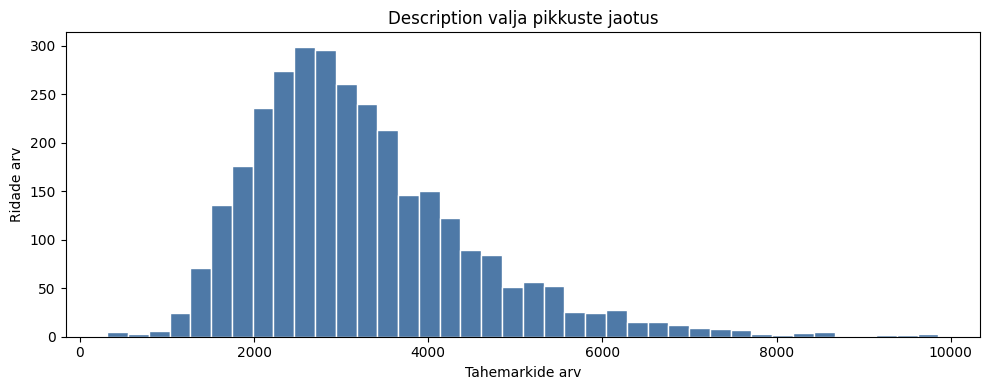

In [10]:
description_length = df_final["description"].fillna("").str.len()

display(description_length.describe().to_frame("description_char_count"))

plt.figure(figsize=(10, 4))
plt.hist(description_length, bins=40, color="#4e79a7", edgecolor="white")
plt.title("Description valja pikkuste jaotus")
plt.xlabel("Tahemarkide arv")
plt.ylabel("Ridade arv")
plt.tight_layout()
plt.show()